###Introduction to Generative Modeling


Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adversarial Networks or GANS, however, use neural networks for a very different purpose: Generative modeling

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.-Source

To get a sense of the power of generative models, just visit thispersondoesnotexist.com. Every time you reload the page, a new image of a person's face is generated on the fly. The results are pretty fascinating

There are many approaches used for generative modeling, a generative adversarial network takes the following approach:


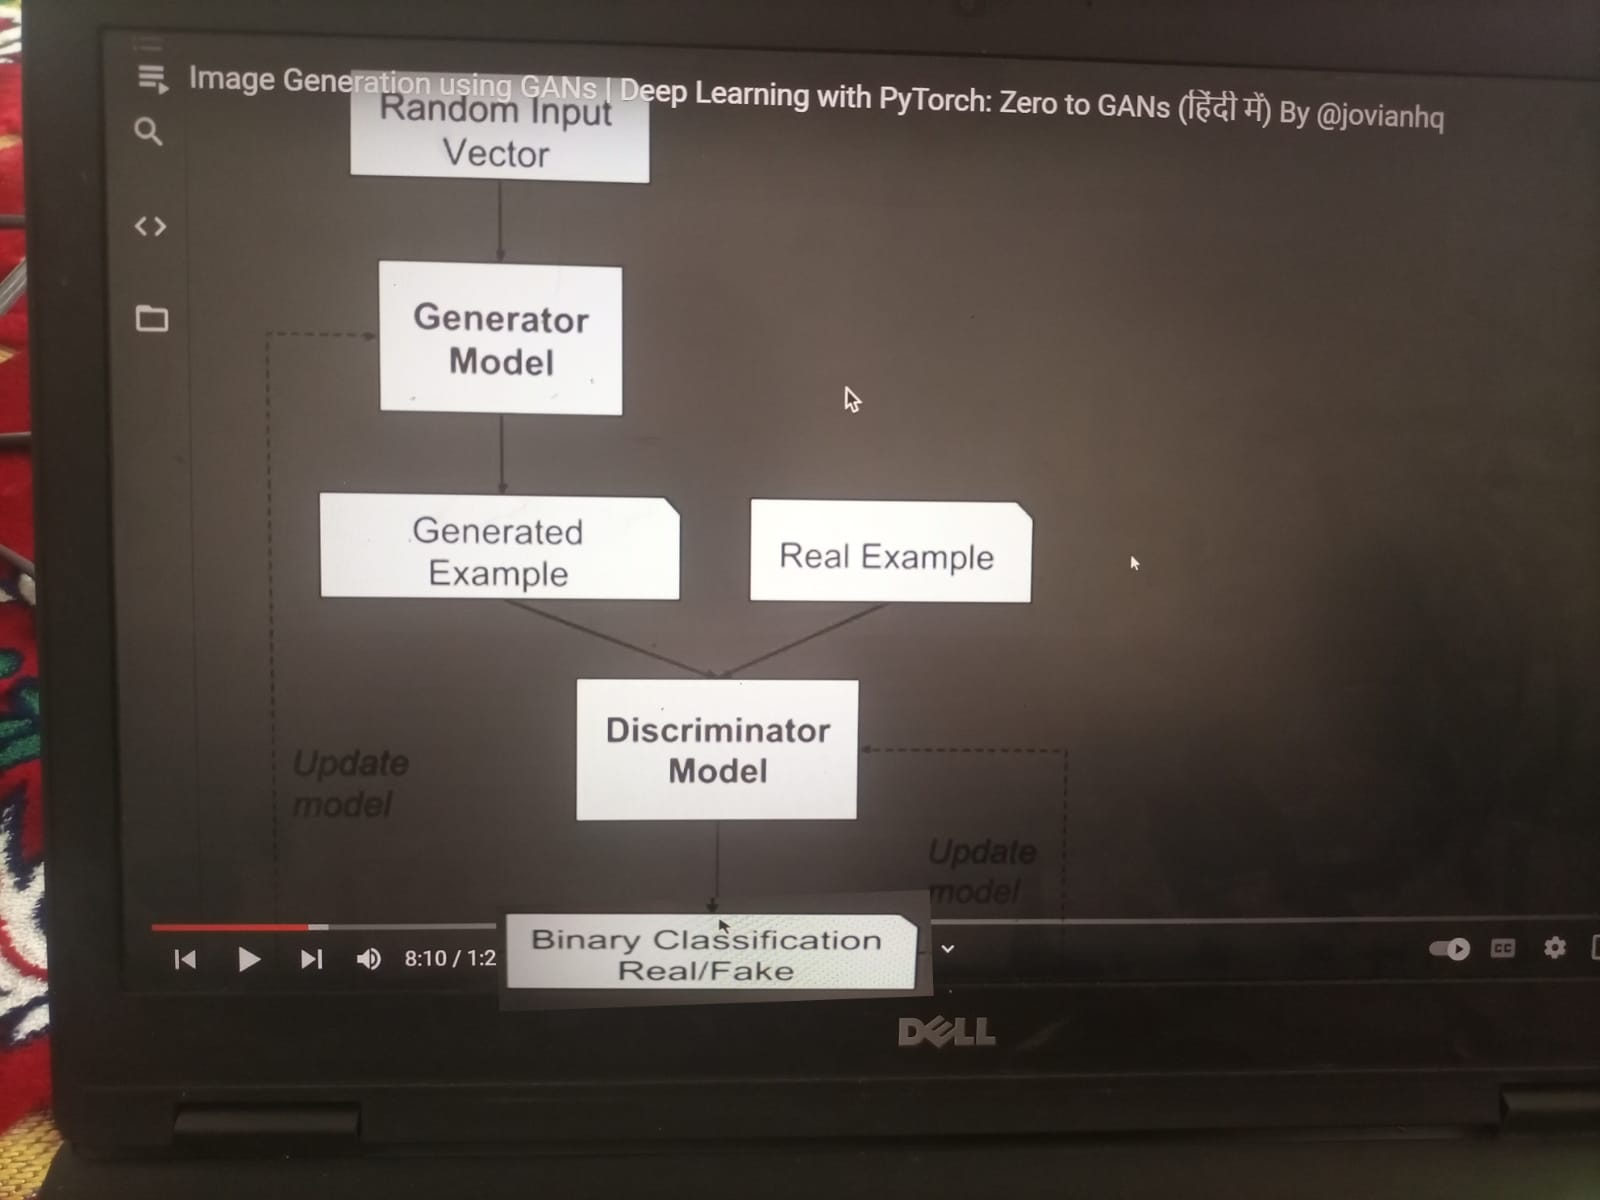

There are two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. <>

GANS however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of anime characters' faces.

###Downloading Kaggle dataset
Sign in to https://kaggle.com/, then click on your profile picture on the top right and select "my account" from the menu. then create the token

In [99]:
!pip install opendatasets --upgrade --quiet

In [100]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/dimensi0n/ffhq-1024'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadikhalas
Your Kaggle Key: ··········


100%|██████████| 7.10G/7.10G [07:13<00:00, 17.6MB/s]


In [2]:
import os

DATA_DIR = './ffhq-1024'
print(os.listdir(DATA_DIR))

['dataset']


In [3]:
print(os.listdir(DATA_DIR+'/dataset')[:10])

['66557.jpg', '30681.jpg', '32024.jpg', '43412.jpg', '69061.jpg', '31491.jpg', '67323.jpg', '54434.jpg', '09266.jpg', '16186.jpg']


Let's load this dataset using the ImageFolder class from torchvision. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range (-1, 1), which is more convenient for training the discriminator. We will also create a data loader to load the data in batches.


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lets create helper functions to demormalize the image ensors and display some sample images from a training batch.


In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

###Denormalize the images

In [8]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach() [:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

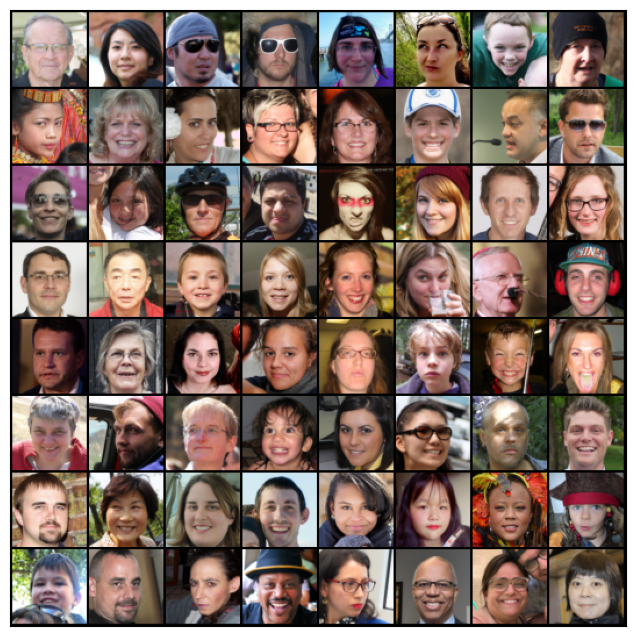

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
  """ Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device=device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)


####Discriminator network
The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [14]:
import torch.nn as nn

In [15]:
discriminator = nn.Sequential(
    #in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
              # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
              # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
              # out: 256 x 8 x 8


     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2, inplace=True),
              # out: 512 x 4 x 4

      nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1


      nn.Flatten(),
      nn.Sigmoid()


)

Note tha we are using the leaky ReLU activation for the discriminator.


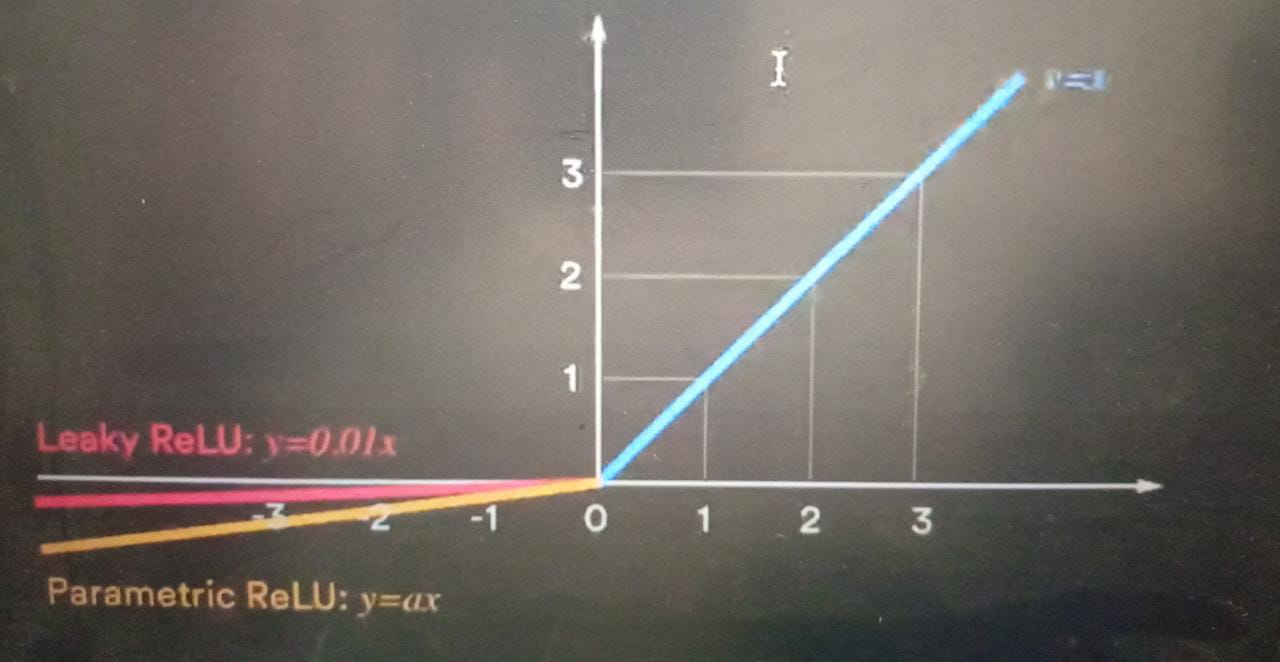

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. -Source

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.

Let's move the discriminator model to the chosen device.

In [16]:
discriminator = to_device(discriminator, device)

###Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128,1,1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the convTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution). Learn

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    #in: 3 x 64 x 64

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
              # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
              # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
              # out: 128 x 16 x 16


    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
              # out: 256 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        # out: 3 x 64 x 64

    nn.Tanh()
    # out: 3 x 64 x 64


)

we use the TanH activation function for the output layer of the generator

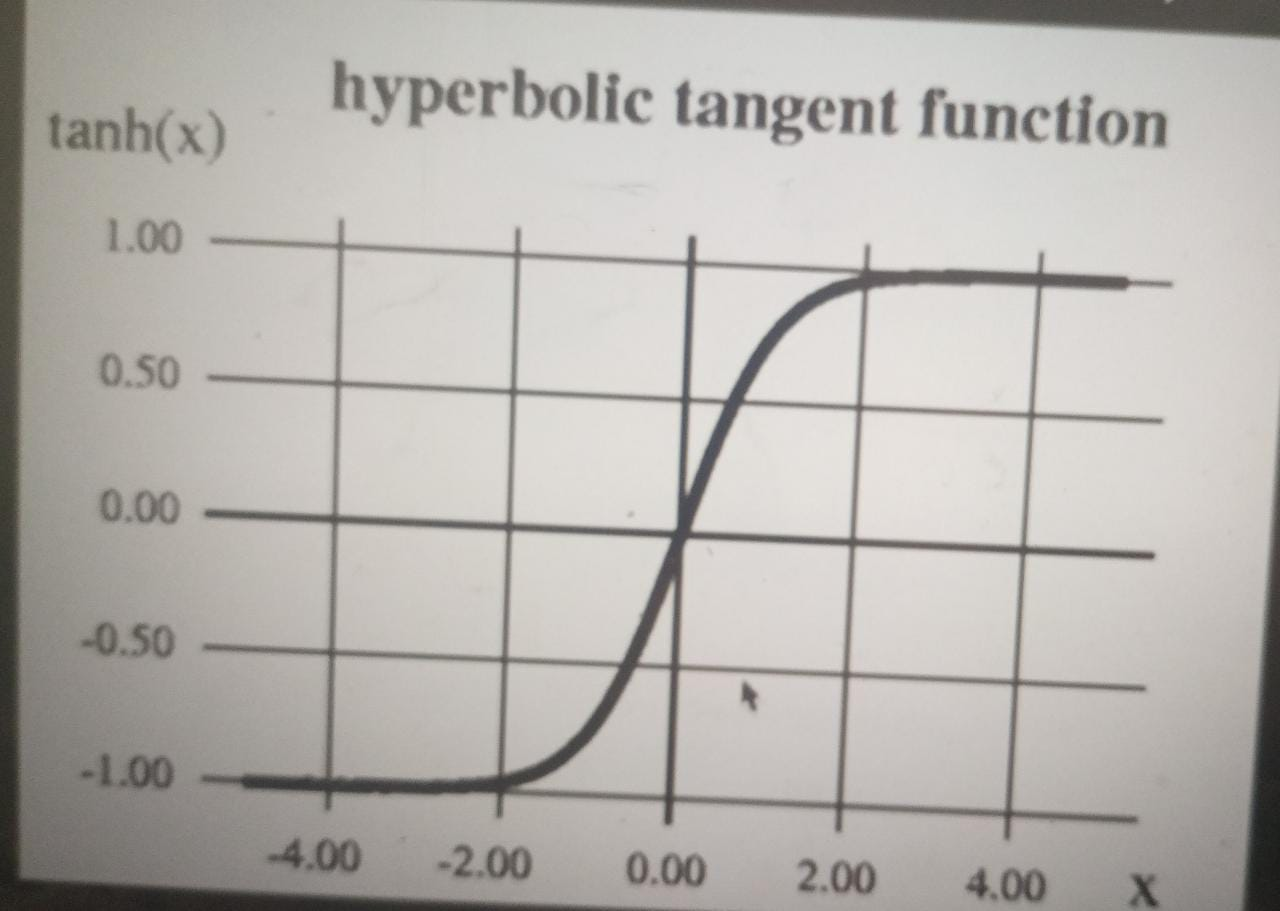

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling."-Source

Note that since the outputs of the TanH activation lie in the range (-1,1), we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([128, 3, 64, 64])


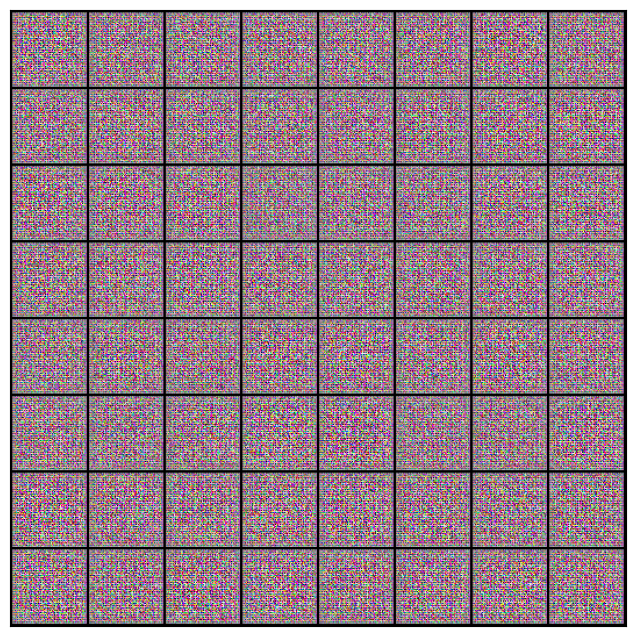

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1)   # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we have not trained it yet.

Let's move the generator to the chose device.

In [20]:
generator = to_device(generator, device)

####Discriminator Training
since the discriminator is a binary classification model, we can use the binary croos entropy loss function to quantifyy how well it is able to differentiate between real and generated images

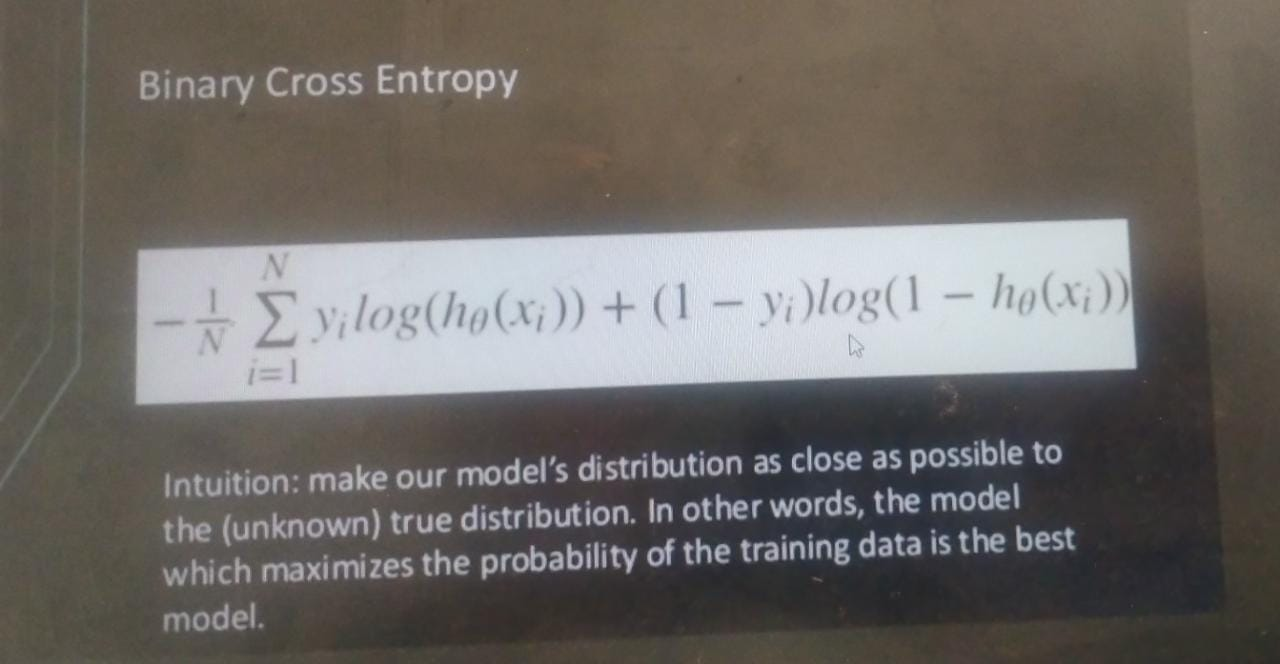

In [21]:
def train_discriminator(real_images, opt_d):
  #clear discriminator gradients
  opt_d.zero_grad()

  #pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()


  #Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)


  #pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  #update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

• We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

• We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then we pass a batch of fake images (generated using the generator) pass them into the discriminator,and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())



▸ Generator Training

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

⚫ We generate a batch of images using the generator, pass the into the discriminator.
• We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

• We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

Here's what this looks like in code.

In [22]:
def train_generator (opt_g):

    #Clear generator gradients

    opt_g.zero_grad()

    # Generate fake images

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

    fake_images = generator(latent)

    # Try to fool the discriminator

    preds = discriminator(fake_images)

    targets = torch.ones(batch_size, 1, device=device)

    loss = F.binary_cross_entropy(preds, targets)

   # Update generator weights

    loss.backward()

    opt_g.step()

    return loss.item()

let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. we will also create a helper function to export the generated images

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generatedFaces'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

we will use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. lets save one set of images before we start training out model

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


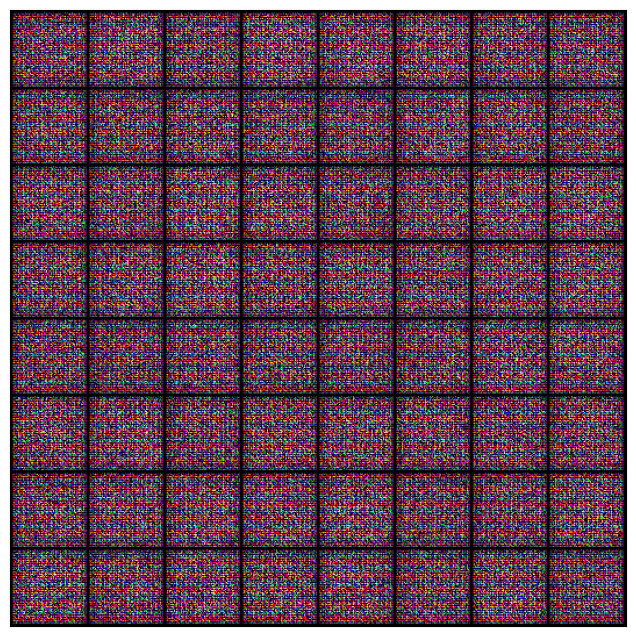

In [27]:
save_samples(0, fixed_latent)

###Full Training Loop

<> Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANS.

We will also save some sample generated images at regular intervals for inspection.

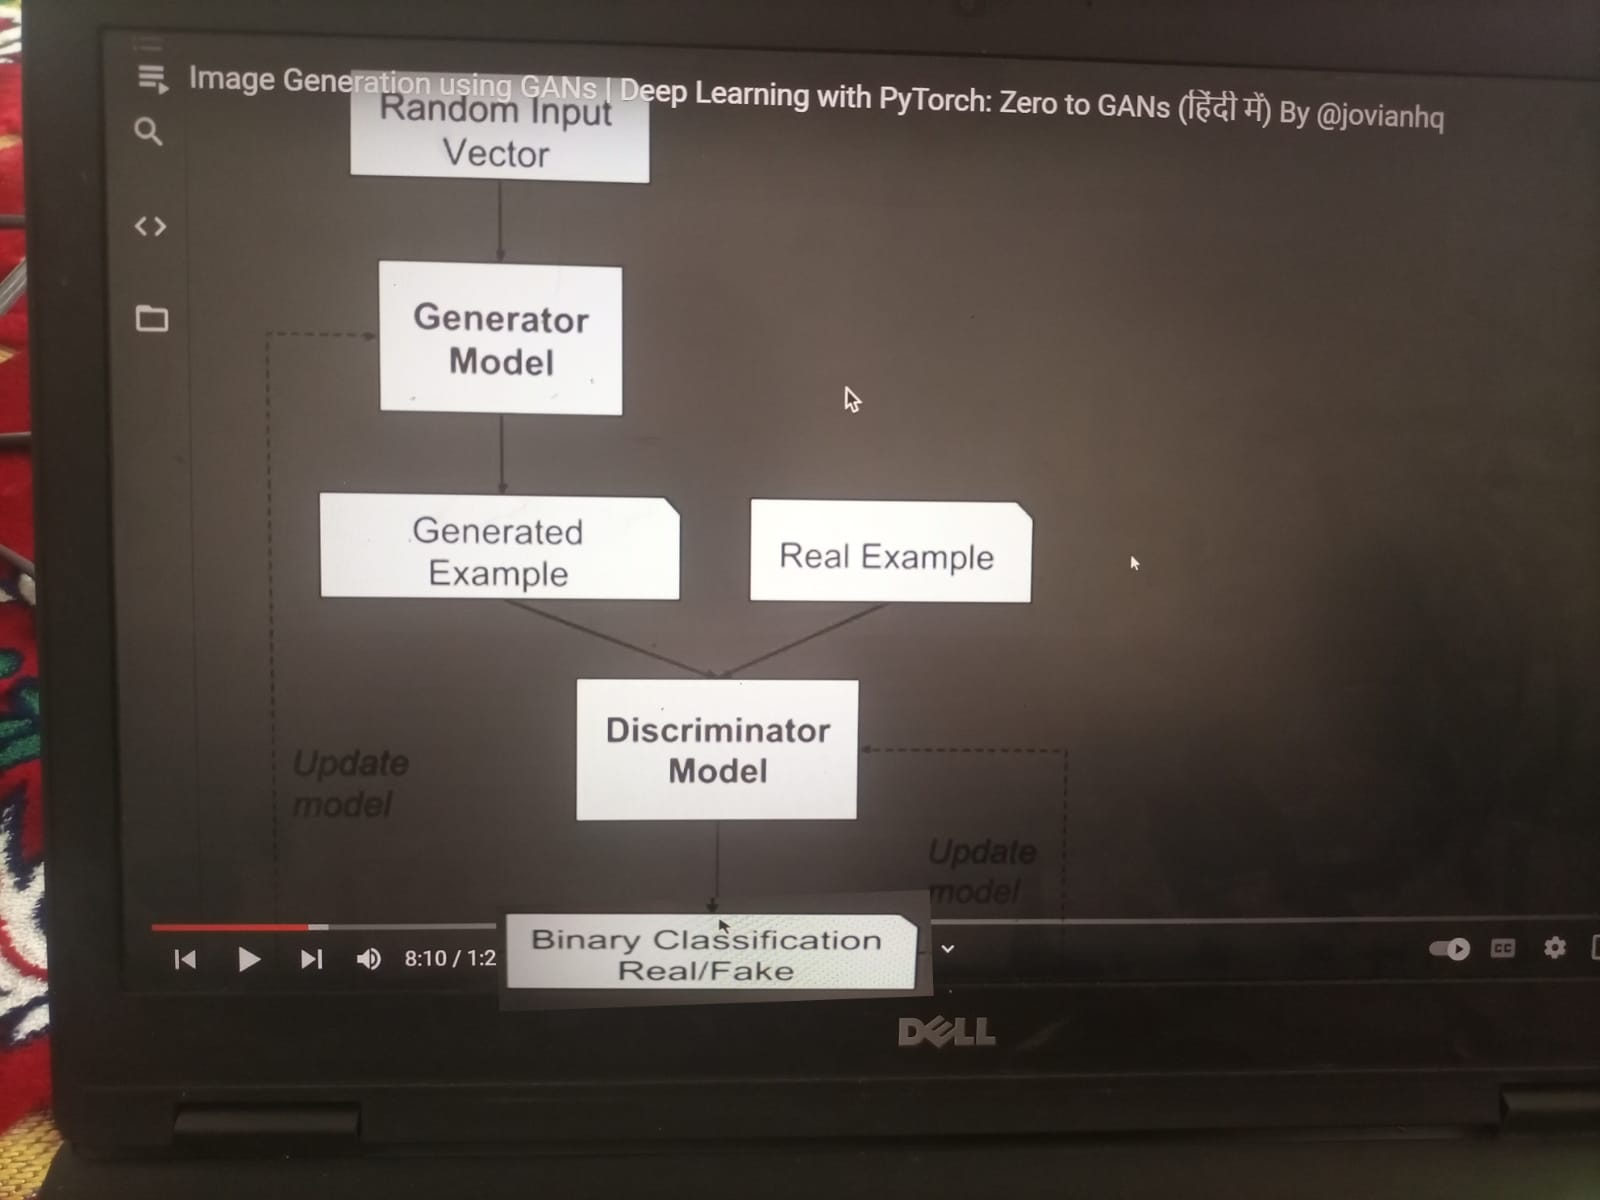

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    #Losses & scores

    losses_g=[]

    losses_d=[]

    real_scores = []

    fake_scores = []

    #Create optimizers

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam (generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
       for real_images, _ in tqdm(train_dl):

          #Train discriminator

          loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

          #Train generator

          loss_g = train_generator(opt_g)
       # Record losses & scores

       losses_g.append(loss_g)

       losses_d.append(loss_d)

       real_scores.append(real_score)

       fake_scores.append(fake_score)

       # Log losses & scores (last batch)

       print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, loss_g, loss_d, real_score, fake_score))


       # Save generated images

       save_samples (epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

we are now ready to train the model.

In [ ]:
lr = 0.0002
epochs = 2

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/547 [00:00<?, ?it/s]

Epoch [1/3], loss_g: 4.2722, loss_d: 0.5120, real_score: 0.8186, fake_score: 0.2333
Saving generated-images-0001.png


  0%|          | 0/547 [00:00<?, ?it/s]

In [85]:
losses_g, losses_d, real_scores, fake_scores = history

In [87]:
from IPython.display import Image

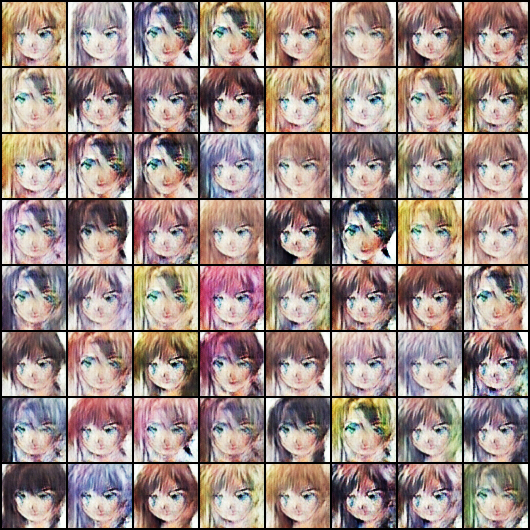

In [88]:
Image("/content/generated/generated-images-0010.png")

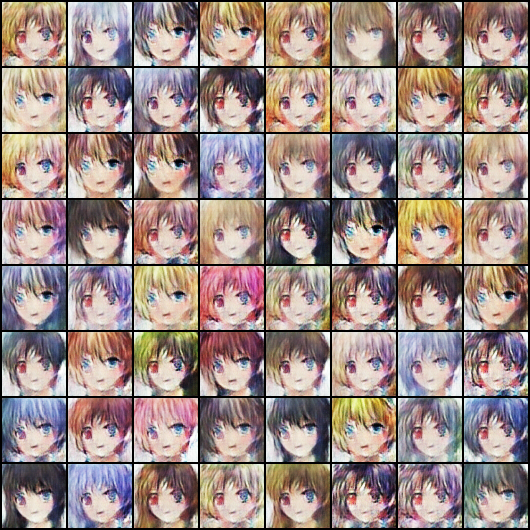

In [89]:
Image("/content/generated/generated-images-0009.png")

In [94]:
import cv2
import os

vid_fname = 'gans_training.mp4'  # Change the extension to 'mp4'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generate' in f]  # Corrected this line
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'mp4v'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


Text(0.5, 1.0, 'Losses')

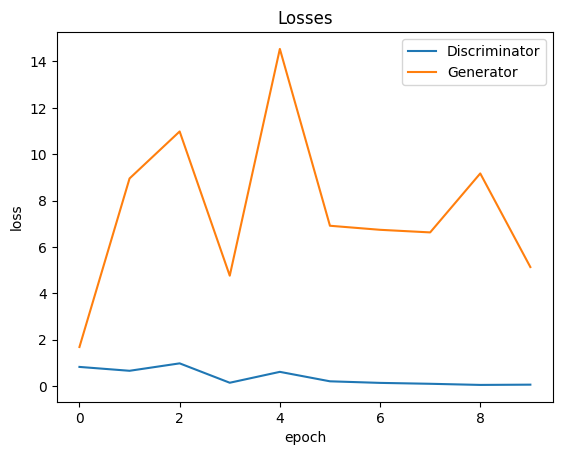

In [97]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

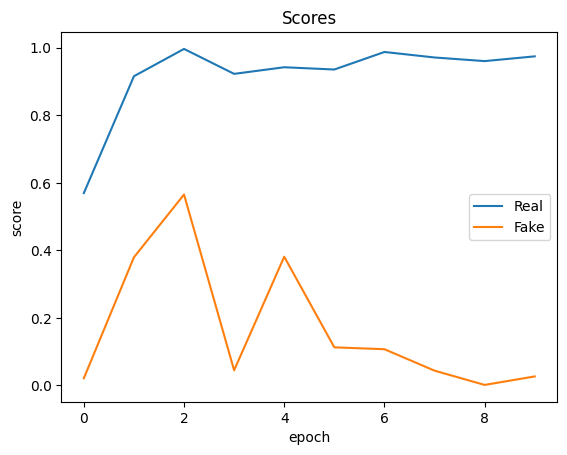

In [98]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

